In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/E-commerce Customer Behavior - Sheet1.csv'
df = pd.read_csv(file_path)
print(df.head())
print("\nShape: ",df.shape)

   Customer ID  Gender  Age           City Membership Type  Total Spend  \
0          101  Female   29       New York            Gold      1120.20   
1          102    Male   34    Los Angeles          Silver       780.50   
2          103  Female   43        Chicago          Bronze       510.75   
3          104    Male   30  San Francisco            Gold      1480.30   
4          105    Male   27          Miami          Silver       720.40   

   Items Purchased  Average Rating  Discount Applied  \
0               14             4.6              True   
1               11             4.1             False   
2                9             3.4              True   
3               19             4.7             False   
4               13             4.0              True   

   Days Since Last Purchase Satisfaction Level  
0                        25          Satisfied  
1                        18            Neutral  
2                        42        Unsatisfied  
3               

In [ ]:
# Drop unnecessary columns
df.drop(columns=['Customer ID'], inplace=True)

# Handle Missing Values - Drop rows with missing target values
df.dropna(subset=['Satisfaction Level'], inplace=True)

# Encode Categorical Variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Satisfaction Level']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encode 'City' and 'Membership Type'
df = pd.get_dummies(df, columns=['City', 'Membership Type'], drop_first=True)

# Convert 'Discount Applied' to integer
df['Discount Applied'] = df['Discount Applied'].astype(int)

# Handle Class Imbalance
X = df.drop(columns=['Satisfaction Level'])
y = df['Satisfaction Level']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


In [ ]:

# Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
# Base Model - Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_pca, y_train)
y_pred_logistic = logistic_model.predict(X_test_pca)

# Ensemble Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [ ]:
# Train and Evaluate Ensemble Models
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n🔹 {name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))



🔹 Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


🔹 AdaBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


🔹 Gradient Boosting Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00     

In [ ]:
# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train_pca, y_train)
y_pred_stacking = stacking_model.predict(X_test_pca)
print("\n🔹 Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))
print(classification_report(y_test, y_pred_stacking))


🔹 Stacking Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [ ]:
# Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)
voting_model.fit(X_train_pca, y_train)
y_pred_voting = voting_model.predict(X_test_pca)
print("\n🔹 Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))





🔹 Voting Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



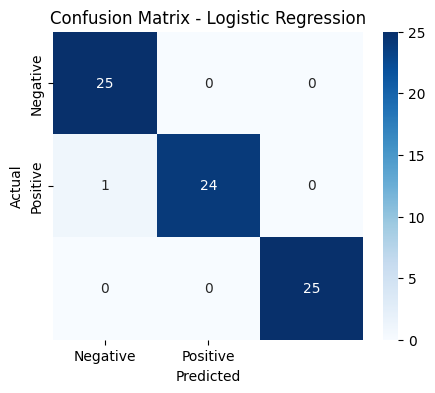

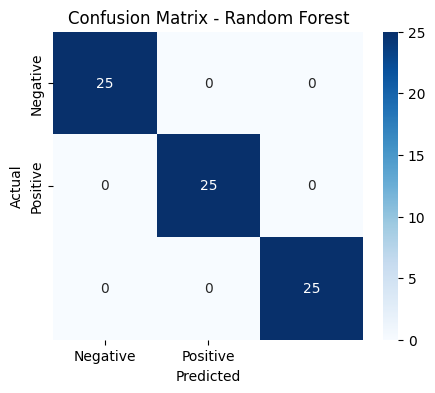

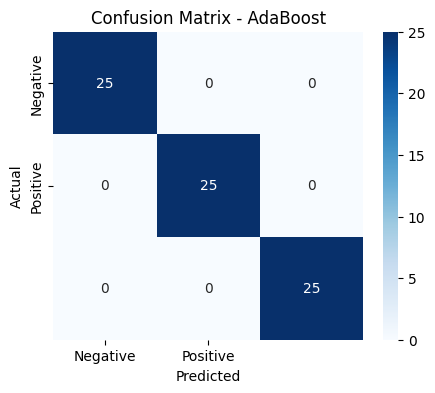

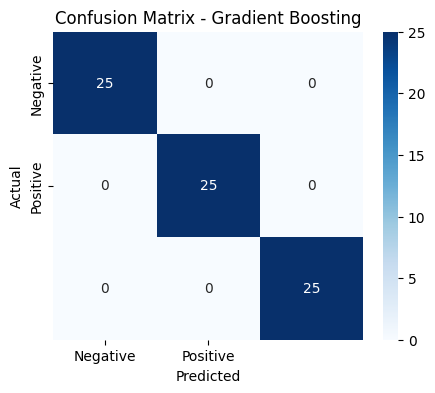

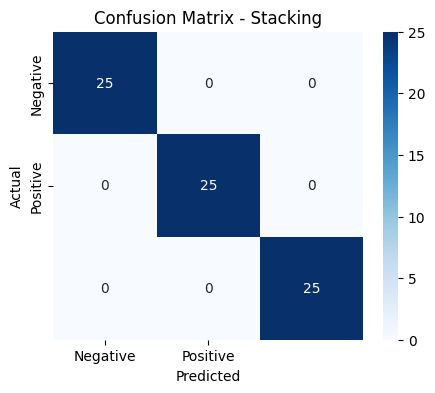

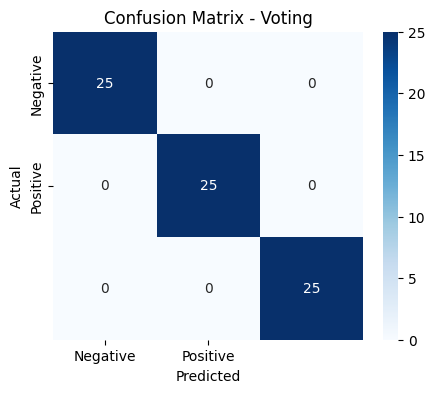

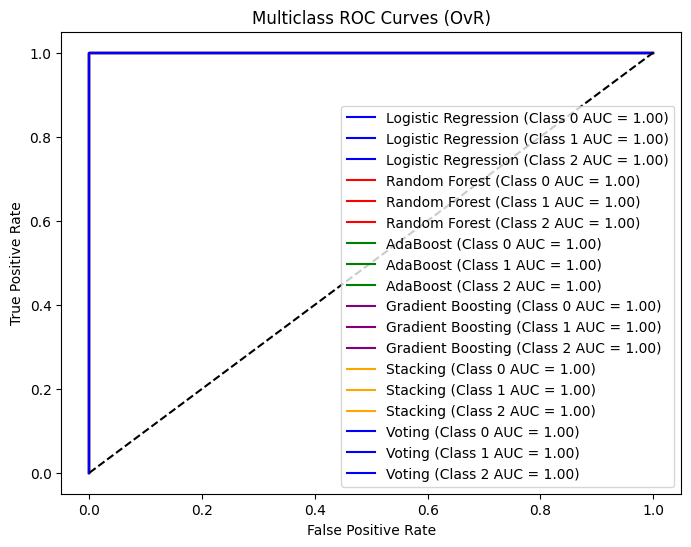

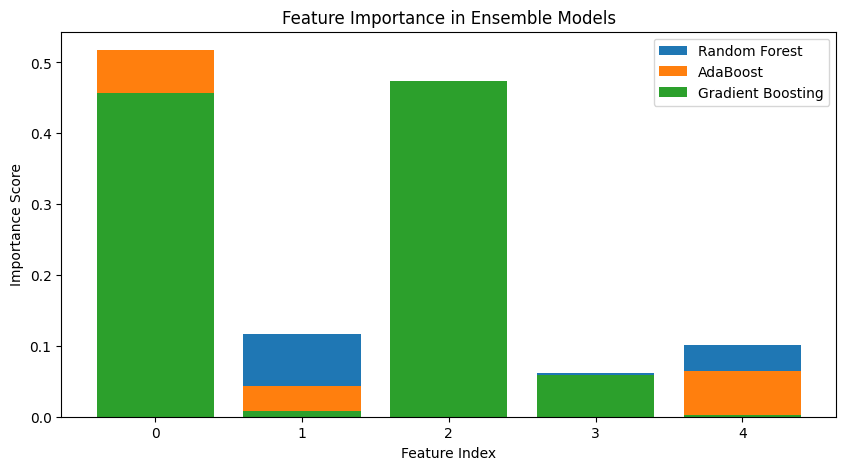

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

# Plot Confusion Matrices
for name, (_, _, y_pred) in results.items():
    plot_confusion_matrix(y_test, y_pred, name)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output (One-hot encoding)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC curve for each model
plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

for (name, (model, _, _)), color in zip(results.items(), colors):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_pca)

        # Compute ROC curve and AUC for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, label=f'{name} (Class {i} AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.show()


# Feature Importance (For Tree-Based Models)
plt.figure(figsize=(10,5))
for name, (model, _, _) in results.items():
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        plt.bar(range(len(importance)), importance, label=name)

plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Ensemble Models")
plt.legend()
plt.show()

